In [1]:
!pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
splitfolders.ratio("/kaggle/input/thesisdataset/thesdats",
                   output="/kaggle/working/dataset_split",
                   ratio=(0.7, 0.15, 0.15))

Copying files: 8614 files [01:18, 109.39 files/s]


In [4]:
data_dir_train = pathlib.Path( '/kaggle/working/dataset_split/train')
img_height,  img_width  = 299, 299

In [5]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123,
                                        image_size=(img_height, img_width))

Found 6027 files belonging to 5 classes.


In [6]:
class_names = train_ds.class_names

In [7]:
class_names

['Acne and Rosacea', 'Bullous', 'Eczema', 'Others', 'Skin cancer']

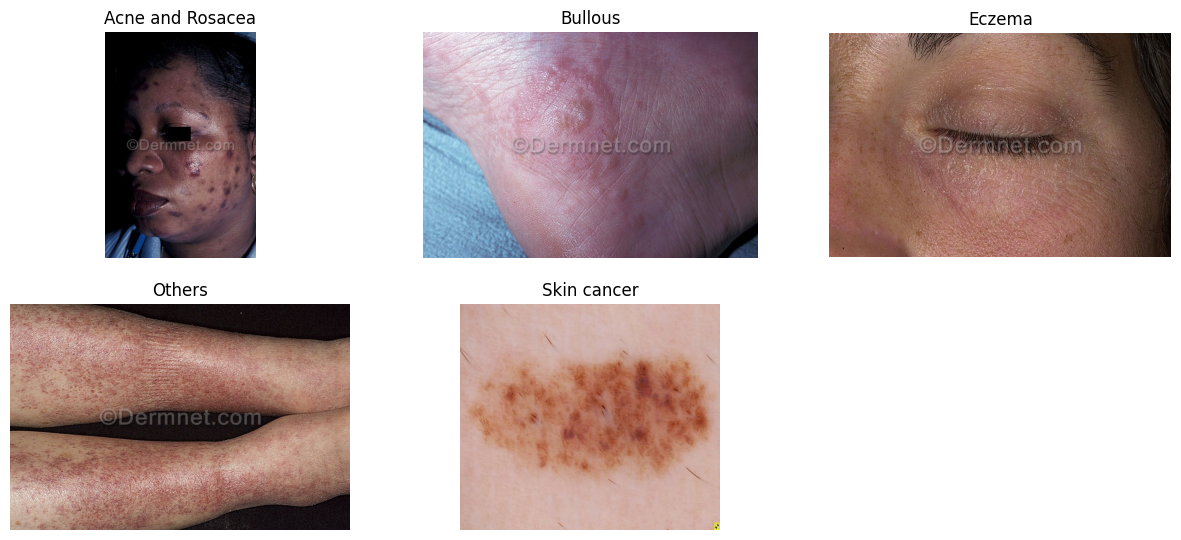

In [8]:
### Visualizing the training data
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)

    # Correct indentation for the following lines
    data_path = os.path.join(str(data_dir_train), class_)
    file_paths = glob.glob(os.path.join(data_path, '*.*'))
    random_img_path = random.choice(file_paths)
    img = PIL.Image.open(random_img_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")

plt.show()

In [9]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.*')))

class_size

{'Acne and Rosacea': 688,
 'Bullous': 503,
 'Eczema': 1497,
 'Others': 1755,
 'Skin cancer': 1584}

In [10]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
Acne and Rosacea,688
Bullous,503
Eczema,1497
Others,1755
Skin cancer,1584


# **Augmentation**

In [11]:
!pip install Augmentor

In [12]:
import Augmentor

In [13]:
path_to_training_dataset = '/kaggle/working/dataset_split/train/'
target_samples = 1500  # Desired number of samples per class

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    existing_samples = len(os.listdir(class_path))  # Count existing images
    additional_samples = max(0, target_samples - existing_samples)  # Calculate needed samples

    if additional_samples > 0:
        p = Augmentor.Pipeline(class_path, output_directory='')

      # 1. Extreme Rotation
        p.rotate(probability=0.9, max_left_rotation=15, max_right_rotation=15)

        # 2. Horizontal & Vertical Flip
        p.flip_left_right(probability=0.8)
        p.flip_top_bottom(probability=0.5)

        # 3. Random Zoom
        p.zoom_random(probability=0.7, percentage_area=0.5)

        # 4. Random Brightness
        p.random_brightness(probability=0.8, min_factor=0.7, max_factor=1.3)

        # 5. Random Contrast
        p.random_contrast(probability=0.7, min_factor=0.7, max_factor=1.3)

        # 6. Shearing
        p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)

        # 7. Skewing
        p.skew(probability=0.4, magnitude=0.2)

        # 8. Gaussian Noise
        p.gaussian_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=3, corner='bell', method='in')


        # 9. Crop & Resize (For additional variation)
        p.crop_random(probability=0.5, percentage_area=0.7)
        p.resize(probability=1.0, width=128, height=128)

      

        # Generate only the necessary number of images
        p.sample(additional_samples)

Initialised with 688 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Acne and Rosacea/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7C8F506C6C80>: 100%|██████████| 812/812 [00:42<00:00, 19.03 Samples/s]


Initialised with 503 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Bullous/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7C8F76185510>: 100%|██████████| 997/997 [00:50<00:00, 19.68 Samples/s]


Initialised with 1497 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7C8F506C7BB0>: 100%|██████████| 3/3 [00:00<00:00, 13.33 Samples/s]


# **Model**

In [14]:
batch_size = 32
img_size = 299

In [15]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,
                               # horizontal flip
                                   brightness_range=[0.2,0.8])

test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
training_set = train_datagen.flow_from_directory('/kaggle/working/dataset_split/train',
                                               target_size=(299,299),
                                                 batch_size=32)

test_set = test_datagen.flow_from_directory('/kaggle/working/dataset_split/val',
                                            target_size=(299,299),
                                            batch_size=32,
                                            shuffle=False)

Found 7839 images belonging to 5 classes.
Found 1290 images belonging to 5 classes.


In [16]:
def Xception():

    engine = tf.keras.applications.Xception(
        # Load the Xception model without the top layer
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 299x299x3
        input_shape = (img_size, img_size, 3),
    )


    # Add custom top layers (Global Average Pooling, Batch Normalization, Dropout, Dense)
    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
    x = tf.keras.layers.BatchNormalization(
        axis=-1,
        momentum=0.99,
        epsilon=0.01,
        center=True,
        scale=True,
        beta_initializer="zeros",
        gamma_initializer="ones",
        moving_mean_initializer="zeros",
        moving_variance_initializer="ones",
    )(x)
    x = tf.keras.layers.Dropout(0.75)(x)
    out = tf.keras.layers.Dense(5,
                                activation='softmax',
                                kernel_regularizer=regularizers.l2(0.02),
                                name='dense_output')(x)


    # Build the Keras model
    model = tf.keras.models.Model(inputs=engine.input, outputs=out)

    # Compile the model
    model.compile(
        # Set optimizer to Adam with learning rate scheduler
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        # Set loss to Categorical Crossentropy
        loss=tf.keras.losses.CategoricalCrossentropy(),
        # Set metrics to accuracy
        metrics=['accuracy']
    )

    return model

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=3,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)


In [18]:
filepath = '/kaggle/working/checkpoint/mymodel-best.keras'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [19]:
os.makedirs('/kaggle/working/Models/categories/', exist_ok=True)


In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

def train():
    time_start = time.time()

    model = Xception()

    model.summary()

    # Calculate class weights
    train_labels = np.array(training_set.classes)  # Get class labels from training set
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )

    # Convert to dictionary, associating class labels with their weights
    class_weight_dict = dict(zip(np.unique(train_labels), class_weights))
    print("Class Weights:", class_weight_dict)


    history = model.fit(
        training_set,
        epochs=50,
        validation_data=test_set,
        class_weight=class_weight_dict,
        callbacks=[early_stopping , learning_rate_reduction , reduce_lr , checkpoint]
    )


    # Final save
    model.save_weights('/kaggle/working/Models/categories/category.weights.h5')
    model.save('/kaggle/working/Models/categories/category.h5')
    print('Model saved.')

    time_end = time.time()
    print('Total training time:', time_end - time_start)
    print('\n')
    
    return history




   

In [21]:
def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod =  keras.models.load_model('/kaggle/working/Models/categories/category.h5')
    mod.evaluate(test_set)

    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1)


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [22]:
input_path = '/kaggle/working/dataset_split/val'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(299, 299))

Found 1290 files belonging to 5 classes.


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,879,917 (79.65 MB)

 Trainable params: 20,821,293 (79.43 MB)

 Non-trainable params: 58,624 (229.00 KB)

Class Weights: {0: 1.0452, 1: 1.0452, 2: 1.0452, 3: 0.8933333333333333, 4: 0.9897727272727272}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


245/245 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.6004 - loss: 1.3217 - val_accuracy: 0.7837 - val_loss: 0.8616 - learning_rate: 3.0000e-04
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7885 - loss: 0.6824 - val_accuracy: 0.8318 - val_loss: 0.5944 - learning_rate: 3.0000e-04
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8546 - loss: 0.5096 - val_accuracy: 0.8364 - val_loss: 0.5484 - learning_rate: 3.0000e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8997 - loss: 0.3819 - val_accuracy: 0.8411 - val_loss: 0.5883 - learning_rate: 3.0000e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9192 - loss: 0.3029 - val_accuracy: 0.8364 - val_loss: 0.5562 - learning_rate: 3.0000e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9346 - loss: 0.2432 - val_accuracy: 0.8488 - val_loss: 0.5041 - learning_rate: 3.0000e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.94

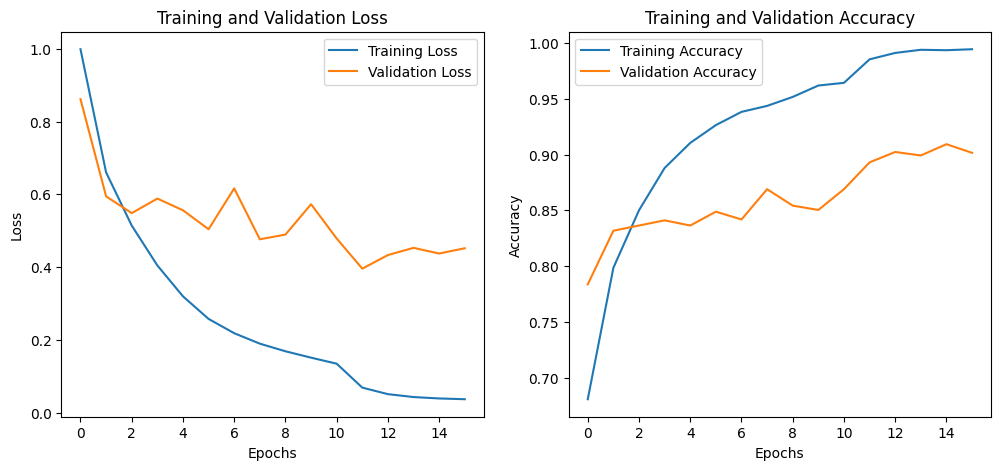

In [23]:
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    key = train_data.class_names
    train_history = train()
    prob, predIdxs, model = test()

    # Plot training history
    plot_training_history(train_history)

# **Testing on test-set**

In [25]:
# Define test data generator for final testing
final_test_datagen = ImageDataGenerator(rescale=1./255)

# Load final test set
final_test_set = final_test_datagen.flow_from_directory('/kaggle/working/dataset_split/test/',
                                                        target_size=(299, 299),
                                                        batch_size=32,
                                                        shuffle=False)  

# Load the model
model = tf.keras.models.load_model('/kaggle/working/Models/categories/category.h5')

# Evaluate the model on the final test set
final_test_loss, final_test_accuracy = model.evaluate(final_test_set)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predicting and classification report
prob = model.predict(final_test_set)
predIdxs = np.argmax(prob, axis=1)

# Get class names from class indices
class_names = list(final_test_set.class_indices.keys())

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(final_test_set.classes, predIdxs, target_names=class_names))


Found 1297 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 647ms/step - accuracy: 0.8284 - loss: 0.8030
Final Test Loss: 0.5927196741104126
Final Test Accuracy: 0.8735543489456177
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step
                  precision    recall  f1-score   support

Acne and Rosacea       0.82      0.85      0.83       148
         Bullous       0.80      0.66      0.72       109
          Eczema       0.82      0.88      0.85       322
          Others       0.85      0.82      0.84       377
     Skin cancer       1.00      1.00      1.00       341

        accuracy                           0.87      1297
       macro avg       0.86      0.84      0.85      1297
    weighted avg       0.87      0.87      0.87      1297



# **Confusion Matrix**

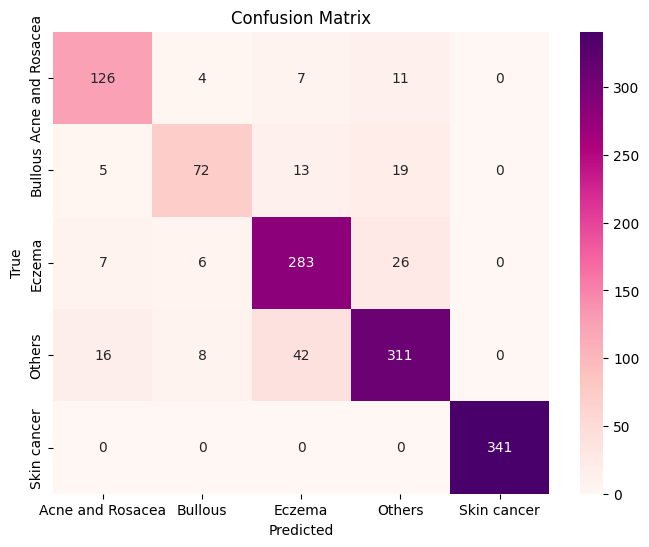

In [26]:
 #Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(final_test_set.classes, predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()